# Linear Regression with SGD

A demonstration of the core workflow for defining and training models using Jax.

## Imports

In [1]:
from typing import List, Tuple

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

## Create Dataset

We create a synthetic dataset by sampling from a linear model with known parameters. We use Numpy for this, as Jax will load it into `DeviceArrays` for us when required. We could have used Jax's pseudo-random number generation as we have done for intitialising the parameters within the training loop below.

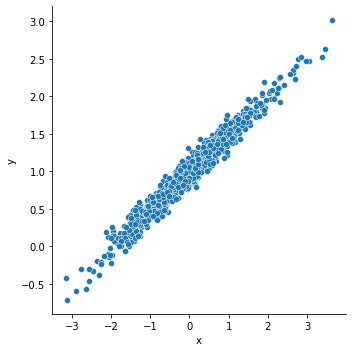

In [2]:
n_obs = 1000

beta_0 = 1.0
beta_1 = 0.5
sigma = 0.1

x_train = np.random.standard_normal(n_obs)
y_train = beta_0 + beta_1 * x_train + sigma * np.random.standard_normal(n_obs)
_ = sns.relplot(x="x", y="y", data=pd.DataFrame({"x": x_train, "y": y_train}))

## Define Model

In [3]:
def model(beta: jnp.DeviceArray, x: jnp.DeviceArray) -> jnp.DeviceArray:
    """1D linear regression."""
    return beta[0] + beta[1] * x


beta = jnp.array([beta_0, beta_1])
x = jnp.array(1.0)
y = model(beta, x)
print(f"y = {y.tolist()}")

y = 1.5


## Define Loss Function

In [4]:
def loss(
    beta: jnp.DeviceArray, x: jnp.DeviceArray, y: jnp.DeviceArray
) -> jnp.DeviceArray:
    """RMSE"""
    return ((model(beta, x) - y) ** 2).mean()


loss(beta, x_train, y_train)

DeviceArray(0.01008753, dtype=float32)

## Define Training Loop

Note, that we use Just-in-Time (JIT) compilation to create an optimised loss function to significantly speed-up the training loop. The compilation, in this particular instance, I believe refers to optimised XLA code.

100%|██████████| 50/50 [00:00<00:00, 676.58it/s]

beta_0 =  0.995
beta_1 =  0.504


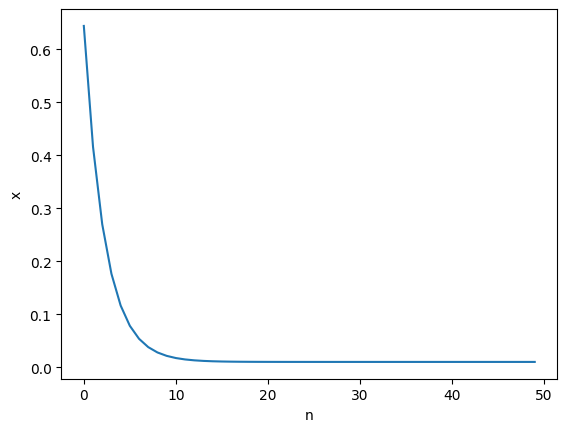

In [5]:
def train(n_iterations: int) -> Tuple[List[float], List[float]]:
    """Train model using gradient descent."""

    @jax.jit
    def update(
        beta: jnp.DeviceArray,
        x: jnp.DeviceArray,
        y: jnp.DeviceArray,
        lr: float = 0.1,
    ):
        return beta - lr * jax.grad(loss)(beta, x, y)

    seed = jax.random.PRNGKey(42)
    beta = jax.random.uniform(seed, (2,))

    loss_hist: List[Tuple[int, float]] = []
    for n in tqdm(range(n_iterations)):
        beta = update(beta, x_train, y_train)
        loss_hist.append((n, loss(beta, x_train, y_train).tolist()))

    return beta.tolist(), loss_hist


beta_est, loss_history = train(50)
print(f"beta_0 = {beta_est[0]: .3f}")
print(f"beta_1 = {beta_est[1]: .3f}")
_ = sns.lineplot(y="x", x="n", data=pd.DataFrame(loss_history, columns=["n", "x"]))